# Analysing network traffic with Pandas

Origianl: Dirk Loss, http://dirk-loss.de, @dloss. 
v1.1, 2013-06-02 

Modified for Python3 on Win32: William George 2015-04-20

This IPython notebook shows how to analyse network traffic using the following tools:
    
* **Pandas**, a Python library for analysing data <http://pandas.pydata.org/>
* **tshark**, the command line version of the Wireshark sniffer <http://http://www.wireshark.org/>
* **Matplotlib**, a Python plotting library <http://matplotlib.org/>

Pandas allows for very flexible analysis, treating your PCAP files as a timeseries of packet data. 

So if the statistics provided by Wireshark are not enough, you might want to try this. And it's more fun, of course. :) 

## Get a PCAP file

First we need a PCAP file. I chose a sample file from the Digital Corpora site that has been used for courses in network forensics:

In [1]:
from IPython.display import HTML
HTML('<iframe src=http://digitalcorpora.org/corpora/scenarios/nitroba-university-harassment-scenario width=600 height=300></iframe>')

In [12]:
# This whole business is totally unnecessary if you're path is setup right.  But if it's not,
#  this is probably easier than actually fixing it.
import os
wireshark_path = "C:\\Program Files\\Wireshark\\" + os.pathsep
# or, if it's under 'program files(x86)'...
# wireshark_path = "C:\\Program Files (x86)\\Wireshark\\" + os.pathsep
os.environ['path'] += wireshark_path

In [2]:
!mkdir -p pcap

In [3]:
cd pcap

C:\Tools\WinPython-64bit-3.4.3.2\notebooks\pcap


We can download it using curl or pure Python. Just uncomment one of the following cells:

In [4]:
#url="http://digitalcorpora.org/corp/nps/packets/2008-nitroba/nitroba.pcap"

In [5]:
# If you have curl installed, we can get nice progress bars:
#!curl -o nitroba.pcap $url

In [6]:
# Or use pure Python:
# import urllib
# urllib.urlretrieve(url, "nitroba.pcap")

In [9]:
ls -l nitroba.pcap

 Volume in drive C has no label.
 Volume Serial Number is E02F-4540

 Directory of C:\Tools\WinPython-64bit-3.4.3.2\notebooks\pcap


 Directory of C:\Tools\WinPython-64bit-3.4.3.2\notebooks\pcap

04/17/2015  02:45 PM        56,180,821 nitroba.pcap
               1 File(s)     56,180,821 bytes
               0 Dir(s)  159,250,518,016 bytes free


In [10]:
#!md5sum nitroba.pcap

## Convert PCAP to a CSV using tshark

We can use the `tshark` command from the Wireshark tool suite to read the PCAP file and convert it into a tab-separated file. This might not be very fast, but it is very flexible, because all of Wireshark's diplay filters can be used to select the packets that we are interested in.

In [13]:
!tshark -v

TShark (Wireshark) 1.99.5 (v1.99.5-0-g7e8595c from master)

Copyright 1998-2015 Gerald Combs <gerald@wireshark.org> and contributors.
License GPLv2+: GNU GPL version 2 or later <http://www.gnu.org/licenses/old-licenses/gpl-2.0.html>
This is free software; see the source for copying conditions. There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

Compiled (64-bit) with WinPcap (4_1_3), with libz 1.2.5, with GLib 2.42.0, with
SMI 0.4.8, with c-ares 1.9.1, with Lua 5.2, with GnuTLS 3.2.15, with Gcrypt
1.6.2, with MIT Kerberos, with GeoIP.

Running on 64-bit Windows 8.1, build 9600, with locale English_United
States.1252, with WinPcap version 4.1.3 (packet.dll version 4.1.0.2980), based
on libpcap version 1.0 branch 1_0_rel0b (20091008), with GnuTLS 3.2.15, with
Gcrypt 1.6.2.
      Intel(R) Core(TM) i7-3630QM CPU @ 2.40GHz (with SSE4.2), with 12240MB of
physical memory.


Built using Microsoft Visual C++ 12.0 build 31101


For now, I just select the frame number and the frame length and redirect the output to a file:

In [14]:
!tshark -n -r nitroba.pcap -T fields -Eheader=y -e frame.number -e frame.len > frame.len

Let's have a look at the file:

In [11]:
# No 'head' on win32 of course.  Implement your own, or just don't.
#!head -10 frame.len

frame.number	frame.len
1	70
2	70
3	1421
4	70
5	1284
6	70
7	70
8	70
9	78


Two columns, tab-separaed. (Not exactly CSV, but who cares. ;-)

Pandas can read those tables into a DataFrame object:

In [15]:
import pandas as pd

In [16]:
df=pd.read_table("frame.len")

The object has a nice default representation that shows the number of values in each row:

In [17]:
df

,frame.number,frame.len
0,1,70
1,2,70
2,3,1421
3,4,70
4,5,1284
5,6,70
6,7,70
7,8,70
8,9,78
9,10,78


Some statistics about the frame length:

In [18]:
df["frame.len"].describe()

count    94410.000000
mean       579.072524
std        625.671800
min         42.000000
25%         70.000000
50%         86.000000
75%       1466.000000
max       1466.000000
Name: frame.len, dtype: float64

The minimum and maximum frame lengths are plausible for an Ethernet connection.

## Plotting

For a better overview, we plot the frame length over time.

We initialise IPython to show inline graphics:

In [19]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Set a figure size in inches:

In [20]:
figsize(10,6)

Pandas automatically uses Matplotlib for plotting. We plot with small dots and an alpha channel of 0.2:

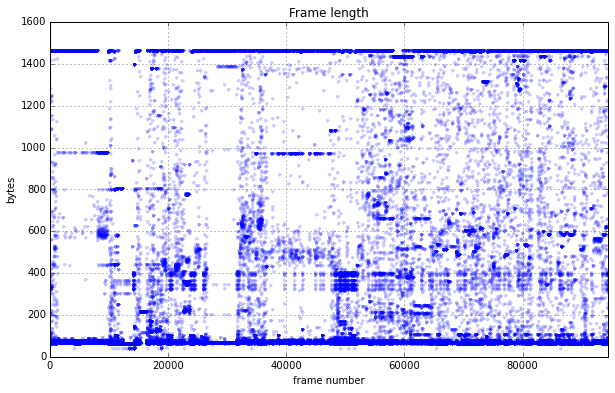

In [21]:
df["frame.len"].plot(style=".", alpha=0.2)
title("Frame length")
ylabel("bytes")
xlabel("frame number")

So there are always lots of small packets (< 100 bytes) and lots of large packets (> 1400 bytes). Some bursts of packets with other sizes (around 400 bytes, 1000 bytes, etc.) can be clearly seen.

### A Python function to read PCAP files into Pandas DataFrames

Passing all those arguments to tshark is quite cumbersome. Here is a convenience function that reads the given fields into a Pandas DataFrame:

In [55]:
import subprocess
import datetime
import pandas as pd

def read_pcap(filename, fields=[], display_filter="", 
              timeseries=False, strict=False):
    """ Read PCAP file into Pandas DataFrame object. 
    Uses tshark command-line tool from Wireshark.

    filename:       Name or full path of the PCAP file to read
    fields:         List of fields to include as columns
    display_filter: Additional filter to restrict frames
    strict:         Only include frames that contain all given fields 
                    (Default: false)
    timeseries:     Create DatetimeIndex from frame.time_epoch 
                    (Default: false)

    Syntax for fields and display_filter is specified in
    Wireshark's Display Filter Reference:
 
      http://www.wireshark.org/docs/dfref/
    """
    if timeseries:
        fields = ["frame.time_epoch"] + fields
    fieldspec = " ".join("-e %s" % f for f in fields)

    display_filters = fields if strict else ['eth']
    if display_filter:
        display_filters.append(display_filter)
    filterspec = '-2 -R "%s"' % " and ".join(f for f in display_filters)

    options = "-r %s -n -T fields -Eheader=y" % filename
    cmd = "tshark %s %s %s" % (options, filterspec, fieldspec)
    proc = subprocess.Popen(cmd, shell = True,
                            stdout=subprocess.PIPE)
    print('filterspec:{0}\n'.format(filterspec),
          'display_filters:{0}\n'.format(display_filters),
          'options:{0}\n'.format(options),
          'cmd:{0}\n'.format(cmd))
    #for line in proc.stdout:
    #    readline(line)
    if timeseries:
        df = pd.read_table(proc.stdout, 
                        index_col = "frame.time_epoch", 
                        parse_dates=True, 
                        date_parser=datetime.datetime.fromtimestamp)
    else:
        df = pd.read_table(proc.stdout)
    return df

We will use this function in my further analysis.

## Bandwidth

By summing up the frame lengths we can calculate the complete (Ethernet) bandwidth used.
First use our convenience function to read the PCAP into a DataFrame:

In [56]:
framelen=read_pcap("nitroba.pcap", ["frame.len"], timeseries=True)
framelen

filterspec:-2 -R "eth"
 display_filters:['eth']
 options:-r nitroba.pcap -n -T fields -Eheader=y
 cmd:tshark -r nitroba.pcap -n -T fields -Eheader=y -2 -R "eth" -e frame.time_epoch -e frame.len



,frame.len
frame.time_epoch,
2008-07-21 19:51:07.095278,70
2008-07-21 19:51:07.103728,70
2008-07-21 19:51:07.114897,1421
2008-07-21 19:51:07.139447,70
2008-07-21 19:51:07.319679,1284
2008-07-21 19:51:07.321990,70
2008-07-21 19:51:07.326516,70
2008-07-21 19:51:07.335554,70
2008-07-21 19:51:07.376171,78


Then we re-sample the timeseries into buckets of 1 second, summing over the lengths of all frames that were captured in that second:

In [57]:
bytes_per_second=framelen.resample("S", how="sum")

Here are the first 5 rows. We get NaN for those timestamps where no frames were captured:

In [58]:
bytes_per_second.head()

,frame.len
frame.time_epoch,
2008-07-21 19:51:07,20729
2008-07-21 19:51:08,8426
2008-07-21 19:51:09,13565
2008-07-21 19:51:10,NaN
2008-07-21 19:51:11,NaN


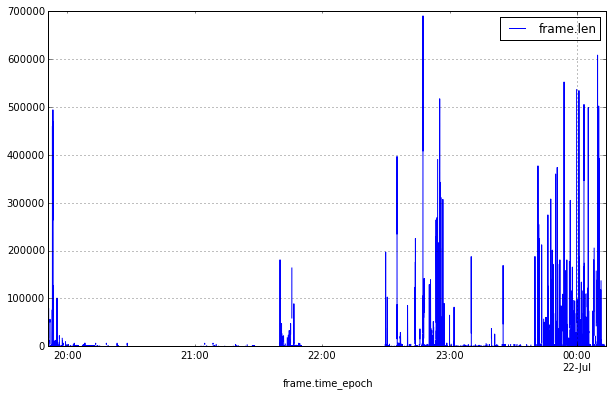

In [59]:
bytes_per_second.plot()

## TCP Time-Sequence Graph

Let's try to replicate the TCP Time-Sequence Graph that is known from Wireshark (Statistics > TCP Stream Analysis > Time-Sequence Graph (Stevens).

In [60]:
fields=["tcp.stream", "ip.src", "ip.dst", "tcp.seq", "tcp.ack", "tcp.window_size", "tcp.len"]
ts=read_pcap("nitroba.pcap", fields, timeseries=True, strict=True)
ts

filterspec:-2 -R "frame.time_epoch and tcp.stream and ip.src and ip.dst and tcp.seq and tcp.ack and tcp.window_size and tcp.len"
 display_filters:['frame.time_epoch', 'tcp.stream', 'ip.src', 'ip.dst', 'tcp.seq', 'tcp.ack', 'tcp.window_size', 'tcp.len']
 options:-r nitroba.pcap -n -T fields -Eheader=y
 cmd:tshark -r nitroba.pcap -n -T fields -Eheader=y -2 -R "frame.time_epoch and tcp.stream and ip.src and ip.dst and tcp.seq and tcp.ack and tcp.window_size and tcp.len" -e frame.time_epoch -e tcp.stream -e ip.src -e ip.dst -e tcp.seq -e tcp.ack -e tcp.window_size -e tcp.len



,tcp.stream,ip.src,ip.dst,tcp.seq,tcp.ack,tcp.window_size,tcp.len
frame.time_epoch,,,,,,,
2008-07-21 19:51:07.095278,0,192.168.1.64,74.125.19.83,1,1,65535,0
2008-07-21 19:51:07.103728,0,74.125.19.83,192.168.1.64,1,2,431,0
2008-07-21 19:51:07.114897,1,192.168.1.64,74.125.19.19,1,1,65535,1351
2008-07-21 19:51:07.139447,1,74.125.19.19,192.168.1.64,1,1352,393,0
2008-07-21 19:51:07.319679,1,74.125.19.19,192.168.1.64,1,1352,393,1214
2008-07-21 19:51:07.321990,1,192.168.1.64,74.125.19.19,1352,1215,65460,0
2008-07-21 19:51:07.326516,1,192.168.1.64,74.125.19.19,1352,1215,65535,0
2008-07-21 19:51:07.335554,1,74.125.19.19,192.168.1.64,1215,1353,393,0
2008-07-21 19:51:07.423663,2,192.168.1.64,74.125.19.103,0,0,65535,0


Now we have to select a TCP stream to analyse. As an example, we just pick stream number 10:

In [80]:
stream=ts[ts["tcp.stream"] == 10]

In [81]:
stream

,tcp.stream,ip.src,ip.dst,tcp.seq,tcp.ack,tcp.window_size,tcp.len
frame.time_epoch,,,,,,,
2008-07-21 19:51:19.259730,10,192.168.1.64,209.3.183.2,0,0,65535,0
2008-07-21 19:51:19.340180,10,209.3.183.2,192.168.1.64,0,1,5840,0
2008-07-21 19:51:19.344786,10,192.168.1.64,209.3.183.2,1,1,65535,0
2008-07-21 19:51:19.351711,10,192.168.1.64,209.3.183.2,1,1,65535,268
2008-07-21 19:51:19.440657,10,209.3.183.2,192.168.1.64,1,269,6432,0
2008-07-21 19:51:19.441668,10,209.3.183.2,192.168.1.64,1,269,6432,641
2008-07-21 19:51:19.450321,10,192.168.1.64,209.3.183.2,269,642,65535,0
2008-07-21 19:51:19.452424,10,192.168.1.64,209.3.183.2,269,642,65535,274
2008-07-21 19:51:19.536224,10,209.3.183.2,192.168.1.64,642,543,7504,1165


Pandas only print the overview because the table is to wide. So we force a display:

In [64]:
print(stream.to_string())

                            tcp.stream        ip.src        ip.dst  tcp.seq  tcp.ack  tcp.window_size  tcp.len
frame.time_epoch                                                                                              
2008-07-21 19:51:19.259730          10  192.168.1.64   209.3.183.2        0        0            65535        0
2008-07-21 19:51:19.340180          10   209.3.183.2  192.168.1.64        0        1             5840        0
2008-07-21 19:51:19.344786          10  192.168.1.64   209.3.183.2        1        1            65535        0
2008-07-21 19:51:19.351711          10  192.168.1.64   209.3.183.2        1        1            65535      268
2008-07-21 19:51:19.440657          10   209.3.183.2  192.168.1.64        1      269             6432        0
2008-07-21 19:51:19.441668          10   209.3.183.2  192.168.1.64        1      269             6432      641
2008-07-21 19:51:19.450321          10  192.168.1.64   209.3.183.2      269      642            65535        0
2

Add a column that shows who sent the packet (client or server). 

The fancy lambda expression is a function that distinguishes between the client and the server side of the stream by comparing the source IP address with the source IP address of the first packet in the stream (for TCP steams that should have been sent by the client).

In [84]:
stream["type"] = stream.apply(lambda x: "client" if x["ip.src"] == stream.irow(0)["ip.src"] else "server", axis=1)

C:\Tools\WinPython-64bit-3.4.3.2\python-3.4.3.amd64\lib\site-packages\IPython\kernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [85]:
print(stream.to_string())

                            tcp.stream        ip.src        ip.dst  tcp.seq  tcp.ack  tcp.window_size  tcp.len    type
frame.time_epoch                                                                                                      
2008-07-21 19:51:19.259730          10  192.168.1.64   209.3.183.2        0        0            65535        0  client
2008-07-21 19:51:19.340180          10   209.3.183.2  192.168.1.64        0        1             5840        0  server
2008-07-21 19:51:19.344786          10  192.168.1.64   209.3.183.2        1        1            65535        0  client
2008-07-21 19:51:19.351711          10  192.168.1.64   209.3.183.2        1        1            65535      268  client
2008-07-21 19:51:19.440657          10   209.3.183.2  192.168.1.64        1      269             6432        0  server
2008-07-21 19:51:19.441668          10   209.3.183.2  192.168.1.64        1      269             6432      641  server
2008-07-21 19:51:19.450321          10  192.168.

In [90]:
client_stream=stream[stream.type == "client"]

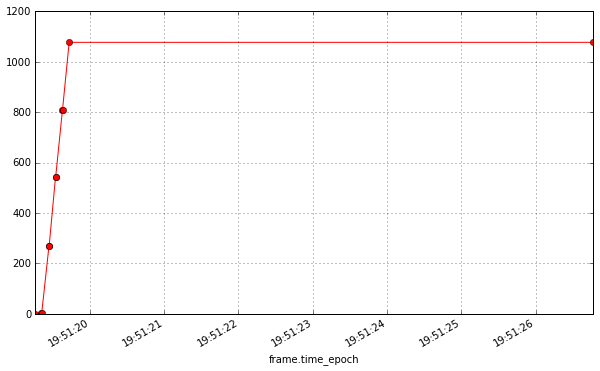

In [91]:
client_stream["tcp.seq"].plot(style="r-o")

Notice that the x-axis shows the real timestamps.

For comparison, change the x-axis to be the packet number in the stream:

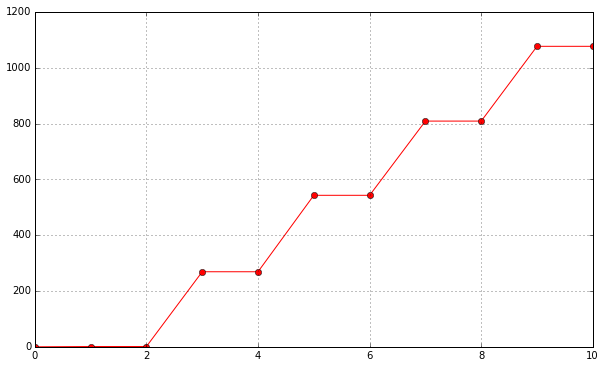

In [69]:
client_stream.index = arange(len(client_stream))
client_stream["tcp.seq"].plot(style="r-o")

Looks different of course.

## Bytes per stream

In [70]:
per_stream=ts.groupby("tcp.stream")
per_stream.head()

,tcp.stream,ip.src,ip.dst,tcp.seq,tcp.ack,tcp.window_size,tcp.len
frame.time_epoch,,,,,,,
2008-07-21 19:51:07.095278,0,192.168.1.64,74.125.19.83,1,1,65535,0
2008-07-21 19:51:07.103728,0,74.125.19.83,192.168.1.64,1,2,431,0
2008-07-21 19:51:07.114897,1,192.168.1.64,74.125.19.19,1,1,65535,1351
2008-07-21 19:51:07.139447,1,74.125.19.19,192.168.1.64,1,1352,393,0
2008-07-21 19:51:07.319679,1,74.125.19.19,192.168.1.64,1,1352,393,1214
2008-07-21 19:51:07.321990,1,192.168.1.64,74.125.19.19,1352,1215,65460,0
2008-07-21 19:51:07.326516,1,192.168.1.64,74.125.19.19,1352,1215,65535,0
2008-07-21 19:51:07.423663,2,192.168.1.64,74.125.19.103,0,0,65535,0
2008-07-21 19:51:07.432369,2,74.125.19.103,192.168.1.64,0,1,5672,0


In [71]:
bytes_per_stream = per_stream["tcp.len"].sum()
bytes_per_stream.head()

tcp.stream
0       0
1    2565
2    5158
3    8266
4    5017
Name: tcp.len, dtype: int64

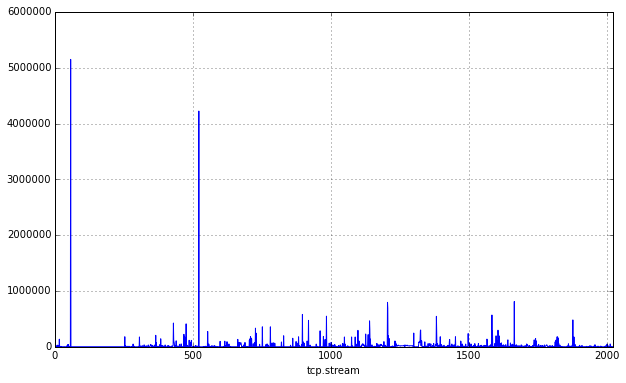

In [72]:
bytes_per_stream.plot()

In [73]:
bytes_per_stream.max()

5150771

In [74]:
biggest_stream=bytes_per_stream.idxmax()
biggest_stream

58

In [75]:
bytes_per_stream.ix[biggest_stream]

5150771

## Ethernet Padding

Let's have a look at the padding of the Ethernet frames. Some cards have been leaking data in the past. For more details, see
http://www.securiteam.com/securitynews/5BP01208UO.html

In [39]:
trailer_df = read_pcap("nitroba.pcap", ["eth.src", "eth.trailer"], timeseries=True)
trailer_df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95175 entries, 2008-07-22 03:51:07.095278 to 2008-07-22 08:13:47.046029
Data columns (total 2 columns):
eth.src        95175  non-null values
eth.trailer    12851  non-null values
dtypes: object(2)

In [40]:
trailer=trailer_df["eth.trailer"]
trailer

frame.time_epoch
2008-07-22 03:51:07.095278    NaN
2008-07-22 03:51:07.103728    NaN
2008-07-22 03:51:07.114897    NaN
2008-07-22 03:51:07.139448    NaN
2008-07-22 03:51:07.319680    NaN
2008-07-22 03:51:07.321990    NaN
2008-07-22 03:51:07.326517    NaN
2008-07-22 03:51:07.335554    NaN
2008-07-22 03:51:07.376171    NaN
2008-07-22 03:51:07.378392    NaN
2008-07-22 03:51:07.389299    NaN
2008-07-22 03:51:07.390478    NaN
2008-07-22 03:51:07.404056    NaN
2008-07-22 03:51:07.416518    NaN
2008-07-22 03:51:07.423663    NaN
...
2008-07-22 08:13:44.266370                  NaN
2008-07-22 08:13:44.266638                  NaN
2008-07-22 08:13:44.293692    00:00:00:00:00:00
2008-07-22 08:13:44.585477                  NaN
2008-07-22 08:13:44.863535                  NaN
2008-07-22 08:13:44.873602                  NaN
2008-07-22 08:13:44.883737                  NaN
2008-07-22 08:13:44.893510                  NaN
2008-07-22 08:13:44.903460                  NaN
2008-07-22 08:13:44.913495           

Ok. Most frames do not seem to have padding, but some have. Let's count per value to get an overview:

In [41]:
trailer.value_counts()

00:00:00:00:00:00                                        7989
3b:02:a7:19:aa:aa:03:00:80:c2:00:07:00:00:00:02:3b:02     913
00:00:00:00:00:00:00:00:00:00:00:00:00:00:00:00:00:00     606
3b:02:a7:19:00:1d:6b:99:98:6a:88:64:11:00:8f:da:00:42     303
00:00                                                     299
00:00:c0:a8:01:40:00:00:00:00:00:00:00:00:00:1d:d9:2e     259
32:01:67:06:aa:aa:03:00:80:c2:00:07:00:00:00:02:3b:02     254
2d:66:6f:6f:65:05:79:61:68:6f:6f:03:63:6f:6d:00:00:01     253
04:67:6b:64:63:03:75:61:73:03:61:6f:6c:03:63:6f:6d:00     160
70:03:6d:73:67:05:79:61:68:6f:6f:03:63:6f:6d:00:00:01     151
73:6b:03:6d:61:63:03:63:6f:6d:00:00:01:00:01:00:01:00     146
2d:66:6f:6f:62:05:79:61:68:6f:6f:03:63:6f:6d:00:00:01     101
73:6b:03:6d:aa:aa:03:00:80:c2:00:07:00:00:00:02:3b:02      66
72:65:76:73:aa:aa:03:00:80:c2:00:07:00:00:00:02:3b:02      54
00:00:00:00:aa:aa:03:00:80:c2:00:07:00:00:00:02:3b:02      52
...
2d:66:6f:6f:aa:aa:03:00:80:c2:00:07:00:00:00:02:3b:02    1
00:00:c

Mostly zeros, but some data. Let's decode the hex strings: 

In [42]:
import binascii

def unhex(s, sep=":"):
    return binascii.unhexlify("".join(s.split(sep)))

In [43]:
s=unhex("3b:02:a7:19:aa:aa:03:00:80:c2:00:07:00:00:00:02:3b:02")
s

';\x02\xa7\x19\xaa\xaa\x03\x00\x80\xc2\x00\x07\x00\x00\x00\x02;\x02'

In [44]:
padding = trailer_df.dropna()

In [45]:
padding["unhex"]=padding["eth.trailer"].map(unhex)

In [46]:
def printable(s):
    chars = []
    for c in s:
        if c.isalnum():
            chars.append(c)
        else:
            chars.append(".")
    return "".join(chars)
           

In [47]:
printable("\x95asd\x33")

'.asd3'

In [48]:
padding["printable"]=padding["unhex"].map(printable)

In [49]:
padding["printable"].value_counts()

......                8145
..................    1927
......k..j.d.....B     303
..                     299
2.g...............     254
.fooe.yahoo.com...     253
.gkdc.uas.aol.com.     160
p.msg.yahoo.com...     151
sk.mac.com........     148
.foob.yahoo.com...     101
sk.m..............      66
revs..............      54
ge.w..............      45
1.1...............      44
.goo..............      42
...
..........Wz......    1
..M...                1
...i.Z                1
..x...                1
..N...                1
..n.oN                1
....fK                1
....fk                1
..Y8..                1
..n.FA                1
...O.r                1
....Qn                1
..PK.e                1
...w..                1
..1...                1
Length: 375, dtype: int64

In [50]:
def ratio_printable(s):
    printable = sum(1.0 for c in s if c.isalnum())
    return printable / len(s)         

In [51]:
ratio_printable("a\x93sdfs")

0.8333333333333334

In [52]:
padding["ratio_printable"] = padding["unhex"].map(ratio_printable)

In [53]:
padding[padding["ratio_printable"] > 0.5]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 727 entries, 2008-07-22 03:51:20.018817 to 2008-07-22 05:40:13.338449
Data columns (total 5 columns):
eth.src            727  non-null values
eth.trailer        727  non-null values
unhex              727  non-null values
printable          727  non-null values
ratio_printable    727  non-null values
dtypes: float64(1), object(4)

In [54]:
_.printable.value_counts()

.fooe.yahoo.com...    253
.gkdc.uas.aol.com.    160
p.msg.yahoo.com...    151
.foob.yahoo.com...    101
.weather.com......     31
ge.weather.com....     26
1.1..HOST.239.255.      1
..CDWW                  1
.foof.yahoo.com...      1
..3rbo                  1
..BIKM                  1
dtype: int64

Now find out which Ethernet cards sent those packets with more than 50% ASCII data in their padding:

In [55]:
padding[padding["ratio_printable"] > 0.5]['eth.src'].drop_duplicates()

frame.time_epoch
2008-07-22 03:51:20.018817    00:1d:d9:2e:4f:61
2008-07-22 04:10:14.155085    00:1d:6b:99:98:68
Name: eth.src, dtype: object

In [56]:
HTML('<iframe src=http://www.coffer.com/mac_find/?string=00%3A1d%3Ad9%3A2e%3A4f%3A61 width=600 height=300></iframe>')

Thats 'Hon Hai Precision' (and "Netopia Inc" for the other MAC address).